In [1]:
import networkx as nx
import pandas as pd
from copy import deepcopy

In [22]:
def get_multi_mixed_arcs_and_edges(G):
    edges = []
    for i, j_dict in G._adj.items():
        for j, neib_dict in j_dict.items():
            for k in neib_dict.keys():
                edges.append([i, j, k])
    return edges

def get_multi_mixed_arcs(G):
    edges = []
    for i, j_dict in G._adj.items():
        for j, neib_dict in j_dict.items():
            for k, vals in neib_dict.items():
                if vals['bidirection'] == False:
                    edges.append([i, j, k])
    return edges

def get_multi_mixed_edges(G):
    edges = []
    for i, j_dict in G._adj.items():
        for j, neib_dict in j_dict.items():
            if j < i:
                continue
            for k, vals in neib_dict.items():
                if vals['bidirection'] == True:
                    edges.append([i, j, k])
    return edges

In [23]:
# from networkx.classes.reportviews import OutMultiEdgeView, OutMultiEdgeDataView

# class MixedMultiEdgeDataView(OutMultiEdgeDataView):
#     """An EdgeDataView class for edges of MultiGraph; See EdgeDataView"""
#     __slots__ = ()

#     def __len__(self):
#         # nbunch makes it hard to count edges between nodes in nbunch
#         return sum(1 for e in self)

#     def __iter__(self):
#         seen = {}
#         for n, nbrs in self._nodes_nbrs():
#             for nbr, kd in nbrs.items():
#                 if nbr not in seen:
#                     for k, dd in kd.items():
#                         yield self._report(n, nbr, k, dd)
#             seen[n] = 1
#         del seen

#     def __contains__(self, e):
#         u, v = e[:2]
#         try:
#             kdict = self._adjdict[u][v]
#         except KeyError:
#             try:
#                 kdict = self._adjdict[v][u]
#             except KeyError:
#                 return False
#         if self.keys is True:
#             k = e[2]
#             try:
#                 dd = kdict[k]
#             except KeyError:
#                 return False
#             return e == self._report(u, v, k, dd)
#         for k, dd in kdict.items():
#             if e == self._report(u, v, k, dd):
#                 return True
#         return False


# class MixedMultiEdgeView(OutMultiEdgeView):
#     """A EdgeView class for edges of a MultiGraph"""
#     __slots__ = ()

#     dataview = MultiEdgeDataView

#     def __len__(self):
#         return sum(len(kdict) for n, nbrs in self._nodes_nbrs()
#                    for nbr, kdict in nbrs.items()) // 2

#     def __iter__(self):
#         seen = {}
#         for n, nbrs in self._nodes_nbrs():
#             for nbr, kd in nbrs.items():
#                 if nbr not in seen:
#                     for k, dd in kd.items():
#                         yield (n, nbr, k)
#             seen[n] = 1
#         del seen

In [24]:
class MixedMultiGraph(nx.MultiGraph):
    def add_arc(self, u, v, key=None, **attr):
        if u not in self._adj:
            self._adj[u] = self.adjlist_inner_dict_factory()
            self._node[u] = {}
        if v not in self._adj:
            self._adj[v] = self.adjlist_inner_dict_factory()
            self._node[v] = {}
        if key is None:
            key = self.new_edge_key(u, v)
        if v in self._adj[u]:
            keydict = self._adj[u][v]
            datadict = keydict.get(key, self.edge_attr_dict_factory())
            datadict.update(attr)
            keydict[key] = datadict
        else:
            # selfloops work this way without special treatment
            datadict = self.edge_attr_dict_factory()
            datadict.update(attr)
            keydict = self.edge_key_dict_factory()
            keydict[key] = datadict
            self._adj[u][v] = keydict
#             G._adj[v][u] = keydict
        return key
    
    def copy(self, as_view=False):
        pass
    

In [25]:
edges = [ # n1, n2, bidirection, required, weight
    (1, 2, True, False, 35),
    (1, 4, True, True, 70),
    (1, 5, False, True, 32),
    (2, 26, False, False, 21),
    (3, 2, False, True, 17),
    (3, 6, False, True, 30),
    (3, 7, True, True, 18),
    (3, 8, True, True, 41),
    (4, 5, True, True, 45),
    (4, 9, True, True, 23),
    (5, 11, False, False, 25),
    (6, 7, True, True, 25),
    (6, 28, True, False, 7),
    (7, 8, True, True, 9),
    (7, 13, True, True, 21),
    (7, 14, True, True, 11),
    (10, 11, False, True, 10),
    (10, 12, True, True, 30),
    (11, 12, True, True, 15),
    (11, 27, False, False, 7),
    (12, 16, True, False, 15),
    (12, 17, True, True, 13),
    (13, 29, True, False, 9),
    (14, 13, False, True, 15),
    (14, 15, False, True, 21),
    (14, 19, True, False, 8),
    (15, 20, True, False, 10),
    (16, 22, True, True, 40),
    (17, 23, True, False, 13),
    (18, 19, False, True, 25),
    (18, 24, True, False, 16),
    (19, 20, True, True, 16),
    (19, 24, True, True, 21),
    (19, 25, True, True, 37),
    (21, 22, True, True, 7),
    (23, 22, False, True, 27),
    (25, 24, False, True, 19),
    (25, 20, False, True, 12),
    (26, 27, True, False, 11),
    (27, 28, False, False, 5),
    (28, 13, False, False, 2),
    (29, 30, True, False, 3),
    (30, 18, False, False, 7),
    (30, 23, False, False, 18)    
]
edges_df = pd.DataFrame(edges)

In [26]:
edges_df.columns = ['n1', 'n2', 'bidirectional', 'required', 'weight']

In [27]:
V_r = set(edges_df.loc[edges_df['required'], ['n1', 'n2']].values.flatten())

In [28]:
def new_arc_key(G, u, v):
    neighbors = G._adj[u]
    if v in neighbors:
        keys = neighbors[v].keys()
        print(keys)
        i = 1
        while 'A{}'.format(i) not in keys:
            i += 1
        return 'A{}'.format(i)
    else:
        return 'A1'

def new_edge_key(G, u, v):
    arc_data = G.get_edge_data(u, v)
    keys = arc_data.keys()
    print(keys)
    i = 1
    while 'A{}'.format(i) not in keys:
        i += 1
    return 'A{}'.format(i)

def add_arc(G, u, v, key=None, **attr):
    """Add an edge between u and v.

    The nodes u and v will be automatically added if they are
    not already in the graph.

    Edge attributes can be specified with keywords or by directly
    accessing the edge's attribute dictionary. See examples below.

    Parameters
    ----------
    u, v : nodes
        Nodes can be, for example, strings or numbers.
        Nodes must be hashable (and not None) Python objects.
    attr : keyword arguments, optional
        Edge data (or labels or objects) can be assigned using
        keyword arguments.

    See Also
    --------
    add_edges_from : add a collection of edges

    Notes
    -----
    Adding an edge that already exists updates the edge data.

    Many NetworkX algorithms designed for weighted graphs use
    an edge attribute (by default `weight`) to hold a numerical value.

    Examples
    --------
    The following all add the edge e=(1, 2) to graph G:

    >>> G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
    >>> e = (1, 2)
    >>> G.add_edge(1, 2)           # explicit two-node form
    >>> G.add_edge(*e)             # single edge as tuple of two nodes
    >>> G.add_edges_from([(1, 2)])  # add edges from iterable container

    Associate data to edges using keywords:

    >>> G.add_edge(1, 2, weight=3)
    >>> G.add_edge(1, 3, weight=7, capacity=15, length=342.7)

    For non-string attribute keys, use subscript notation.

    >>> G.add_edge(1, 2)
    >>> G[1][2].update({0: 5})
    >>> G.edges[1, 2].update({0: 5})
    """
    
    if G.is_multigraph():
        if u not in G._adj:
            G._adj[u] = G.adjlist_inner_dict_factory()
            G._node[u] = {}
        if v not in G._adj:
            G._adj[v] = G.adjlist_inner_dict_factory()
            G._node[v] = {}
        if key is None:
            key = new_arc_key(G, u, v)
        if v in G._adj[u]:
            keydict = G._adj[u][v]
            datadict = keydict.get(key, G.edge_attr_dict_factory())
            datadict.update(attr)
            keydict[key] = datadict
        else:
            # selfloops work this way without special treatment
            datadict = G.edge_attr_dict_factory()
            datadict.update(attr)
            keydict = G.edge_key_dict_factory()
            keydict[key] = datadict
            G._adj[u][v] = keydict
#             G._adj[v][u] = keydict
        return key
    else:
        # add nodes
        if u not in G._node:
            G._adj[u] = G.adjlist_inner_dict_factory()
            G._node[u] = {}
        if v not in G._node:
            G._adj[v] = G.adjlist_inner_dict_factory()
            G._node[v] = {}
        # add the edge
        datadict = G._adj[u].get(v, G.edge_attr_dict_factory())
        datadict.update(attr)
        G._adj[u][v] = datadict
        return None

def remove_arc_from(G, u, v, key=None):  
    try:
        d = G._adj[u][v]
    except KeyError:
        raise NetworkXError(
            "The edge %s-%s is not in the graph." % (u, v))
    # remove the edge with specified data
    if key is None:
        d.popitem()
    else:
        try:
            del d[key]
        except KeyError:
            msg = "The edge %s-%s with key %s is not in the graph."
            raise NetworkXError(msg % (u, v, key))
    if len(d) == 0:
        # remove the key entries if last edge
        del G._adj[u][v]

    

In [29]:
G_all_arcs = nx.MultiDiGraph()
G_all = nx.MultiGraph()
G_req = nx.MultiGraph()
G_not_req_arcs = nx.MultiDiGraph()
G_not_req = nx.MultiGraph()
G_req_arcs = nx.MultiDiGraph()


# def add_arc(graph, node1, node2, weight, required):
#     if isinstance(graph, nx.DiGraph):
#         graph.add_edge(node1, node2, weight=weight, bidirection=False, required=required)
#     else:
#         graph.add_edge(node1, node2, weight=weight, bidirection=False, required=required)
#         del graph._adj[node2][node1]



for i, row in edges_df[(~edges_df['bidirectional'])  & ~(edges_df['required'])].iterrows():
    for graph in [G_all_arcs, G_all, G_not_req, G_not_req_arcs]:
        add_arc(graph, row['n1'], row['n2'], key='A1', weight=row['weight'], required=False, bidirection=False)
    
for i, row in edges_df[(~edges_df['bidirectional']) & (edges_df['required'])].iterrows():
    for graph in [G_all_arcs, G_all, G_req, G_req_arcs]:
        add_arc(graph, row['n1'], row['n2'], key='A1', weight=row['weight'], required=True, bidirection=False)

In [30]:
edges_df[(edges_df['bidirectional']) & (edges_df['required'])]

,n1,n2,bidirectional,required,weight
1,1,4,True,True,70
6,3,7,True,True,18
7,3,8,True,True,41
8,4,5,True,True,45
9,4,9,True,True,23
11,6,7,True,True,25
13,7,8,True,True,9
14,7,13,True,True,21
15,7,14,True,True,11
17,10,12,True,True,30


In [31]:
G_all_edges = nx.MultiGraph()
G_req_edges = nx.MultiGraph()
G_not_req_edges = nx.MultiGraph()
G_req_edges = nx.MultiGraph()

for i, row in edges_df[(edges_df['bidirectional']) & (edges_df['required'])].iterrows():
    for graph in [G_all_edges, G_req_edges, G_all, G_req]: 
        graph.add_edge(row['n1'], row['n2'], key='E1', weight=row['weight'], bidirection=True, required=True)

for i, row in edges_df[(edges_df['bidirectional']) & ~(edges_df['required'])].iterrows():
    for graph in [G_all_edges, G_not_req_edges, G_all, G_not_req]: 
        graph.add_edge(row['n1'], row['n2'], key='E1', weight=row['weight'], bidirection=True, required=False)

print(G_req._adj[19])    
print(G_req._adj[25])    

G_prime = deepcopy(G_req)
# for i, row in edges_df[edges_df['required']].iterrows():
#     G_prime.add_edge(row['n1'], row['n2'], weight=row['weight'], bidi)


{20: {'E1': {'weight': 16, 'bidirection': True, 'required': True}}, 24: {'E1': {'weight': 21, 'bidirection': True, 'required': True}}, 25: {'E1': {'weight': 37, 'bidirection': True, 'required': True}}}
{24: {'A1': {'weight': 19, 'required': True, 'bidirection': False}}, 20: {'A1': {'weight': 12, 'required': True, 'bidirection': False}}, 19: {'E1': {'weight': 37, 'bidirection': True, 'required': True}}}


In [32]:
G_all._adj[2]

{26: {'A1': {'weight': 21, 'required': False, 'bidirection': False}},
 1: {'E1': {'weight': 35, 'bidirection': True, 'required': False}}}

In [33]:
list(nx.connected_components(G_req))

[{1, 4, 5, 9},
 {2, 3, 6, 7, 8, 13, 14, 15},
 {10, 11, 12, 17},
 {18, 19, 20, 24, 25},
 {16, 21, 22, 23}]

***Create Gprime by adding links from pairs of V_R***

In [34]:
from itertools import permutations
from networkx.algorithms.shortest_paths import dijkstra_path, shortest_path_length
from collections import defaultdict
shortest_paths = defaultdict(dict)
dijkstra_paths = defaultdict(dict)
to_add = set()
to_delete = set()
for i, j in (permutations(V_r, 2)):
    # check if already adjacent
    if j in G_prime._adj.get(i, set()):
        continue
    
    path_ij = shortest_paths.get(i, {}).get(j)
    if path_ij is None:
        path_ij = shortest_path_length(G_all, i, j, weight='weight')
        shortest_paths[i][j] = path_ij
        dijkstra_paths[i][j] = dijkstra_path(G_all, i, j, weight='weight')
    delete_ij = False
    for k in V_r - {i, j}:
        path_ik = shortest_paths.get(i, {}).get(k)
        if path_ik is None:
            path_ik = shortest_path_length(G_all, i, k, weight='weight')
            shortest_paths[i][k] = path_ik
        path_kj = shortest_paths.get(k, {}).get(j)
        if path_kj is None:
            path_kj = shortest_path_length(G_all, k, j, weight='weight')
            shortest_paths[k][j] = path_kj
        if path_ik + path_kj <= path_ij:
            delete_ij = True
            break
    if delete_ij:
        to_delete.add((i, j))
    else:
        to_add.add((i, j))

In [35]:
to_add

{(1, 2),
 (2, 1),
 (2, 6),
 (2, 13),
 (5, 11),
 (6, 13),
 (11, 6),
 (11, 13),
 (12, 16),
 (13, 18),
 (13, 23),
 (14, 19),
 (15, 20),
 (16, 12),
 (17, 23),
 (18, 24),
 (19, 14),
 (20, 15),
 (23, 17),
 (24, 18)}

In [36]:
for i, j in to_add:
    print('-------------')
    print('adding(i:{}, j:{})'.format(i, j))
    print('before')
    print(G_prime.adj[i])
    print(G_prime.adj[j])
    add_arc(G_prime, i, j, weight=shortest_paths[i][j], required=False, bidirection=False)
    print('after')
    print(G_prime.adj[i])
    print(G_prime.adj[j])


-------------
adding(i:1, j:2)
before
{5: {'A1': {'weight': 32, 'required': True, 'bidirection': False}}, 4: {'E1': {'weight': 70, 'bidirection': True, 'required': True}}}
{}
after
{5: {'A1': {'weight': 32, 'required': True, 'bidirection': False}}, 4: {'E1': {'weight': 70, 'bidirection': True, 'required': True}}, 2: {'A1': {'weight': 35, 'required': False, 'bidirection': False}}}
{}
-------------
adding(i:2, j:6)
before
{}
{7: {'E1': {'weight': 25, 'bidirection': True, 'required': True}}}
after
{6: {'A1': {'weight': 44, 'required': False, 'bidirection': False}}}
{7: {'E1': {'weight': 25, 'bidirection': True, 'required': True}}}
-------------
adding(i:13, j:23)
before
{7: {'E1': {'weight': 21, 'bidirection': True, 'required': True}}}
{22: {'A1': {'weight': 27, 'required': True, 'bidirection': False}}}
after
{7: {'E1': {'weight': 21, 'bidirection': True, 'required': True}}, 23: {'A1': {'weight': 30, 'required': False, 'bidirection': False}}}
{22: {'A1': {'weight': 27, 'required': True, '

In [37]:
G_prime._adj[16]

{22: {'E1': {'weight': 40, 'bidirection': True, 'required': True}},
 12: {'A1': {'weight': 15, 'required': False, 'bidirection': False}}}

In [38]:
G_all._adj[2]

{26: {'A1': {'weight': 21, 'required': False, 'bidirection': False}},
 1: {'E1': {'weight': 35, 'bidirection': True, 'required': False}}}

In [39]:
# replace required Edges with arcs
# reducing the number of conneted components induced by the set E_R U A_R in G'
# computing the minimum number of times some arcs have to be traversed

In [63]:
def is_cut_edge(G, i, j):
    Gc = deepcopy(G)
    Gc.remove_edges_from([(i, j)])
    Gc1 = deepcopy(Gc)
    Gc2 = deepcopy(Gc)
    add_arc(Gc1, i, j, key='A1', weight=1, required=False)
    add_arc(Gc2, j, i, key='A1', weight=1, required=False)
    return not nx.is_strongly_connected(Gc1), not nx.is_strongly_connected(Gc2)


def is_cut_arc(G, i, j):
    Gc = deepcopy(G)
    remove_arc_from(Gc, i, j)
    return not nx.is_strongly_connected(Gc)

In [64]:
cut_edges = {}

edges = get_multi_mixed_edges(G_prime)
print(edges)
for i, j, key in edges:
    data = G_prime.get_edge_data(i, j)
    #print(data)
    print(i, j, is_cut_edge(G_prime, i, j))
    cut_edge = is_cut_edge(G_prime, i, j)
    cut_edges[(i, j)] = cut_edge

    # if an edge is a cutting edge in 1 direction, then it will not
    # be traversed the other way in an optimal solution

    if not cut_edge[0] and cut_edge[1]:
        print('removing from {} to {}'.format(j, i))
        orig_weight = G_prime.get_edge_data(i, j)[key]['weight']
        print('weight', G_prime.get_edge_data(i, j), orig_weight)
        G_prime.remove_edges_from([(j, i)])
        add_arc(G_prime, i, j, key='A1', weight=orig_weight, required=True, bidirection=False)

        print(G_prime.get_edge_data(i, j))

    elif not cut_edge[1] and cut_edge[0]:
        print('removing from {} to {}'.format(i, j))
        orig_weight = G_prime.get_edge_data(j, i)[key]['weight']
        print('weight', G_prime.get_edge_data(j, i), orig_weight)

        G_prime.remove_edges_from([(i, j)])
        add_arc(G_prime, j, i, key='A1', weight=orig_weight, required=True, bidirection=False)

        print(G_prime.get_edge_data(j, i))

    # if an edge is a cut edge then it must be traversed exactly once in each direction
    # by each direction by every optimal solution

[[1, 4, 'E1'], [3, 7, 'E1'], [3, 8, 'E1'], [6, 7, 'E1'], [11, 12, 'E1'], [19, 20, 'E1'], [19, 24, 'E1'], [4, 5, 'E1'], [7, 8, 'E1'], [7, 13, 'E1'], [7, 14, 'E1'], [12, 17, 'E1'], [16, 22, 'E1']]


NetworkXNotImplemented: not implemented for undirected type

In [44]:
cut_arcs = {}

arcs = get_multi_mixed_arcs(G_prime)
print(arcs)
for i, j, key in arcs:
    data = G_prime.get_edge_data(i, j, key)
    #print(i, j, data)
    is_cut = is_cut_arc(G_prime, i, j)
    if is_cut:
        print(i, j, is_cut_arc(G_prime, i, j))
        cut_arcs[(i, j)] = is_cut
            
        # if an edge is a cutting edge in 1 direction, then it will not
        # be traversed the other way in an optimal solution
        
        
        # not doing anything with this now

[[1, 5, 'A1'], [1, 2, 'A1'], [5, 11, 'A1'], [3, 2, 'A1'], [3, 6, 'A1'], [2, 6, 'A1'], [2, 1, 'A1'], [2, 13, 'A1'], [6, 13, 'A1'], [10, 11, 'A1'], [11, 6, 'A1'], [11, 13, 'A1'], [14, 13, 'A1'], [14, 15, 'A1'], [14, 19, 'A1'], [13, 23, 'A1'], [13, 18, 'A1'], [15, 20, 'A1'], [18, 19, 'A1'], [18, 24, 'A1'], [19, 14, 'A1'], [19, 25, 'A1'], [23, 22, 'A1'], [23, 17, 'A1'], [22, 21, 'A1'], [25, 24, 'A1'], [25, 20, 'A1'], [24, 18, 'A1'], [20, 15, 'A1'], [4, 9, 'A1'], [12, 16, 'A1'], [12, 10, 'A1'], [17, 23, 'A1'], [16, 12, 'A1']]
19 25 True
22 21 True
4 9 True
12 10 True


In [46]:
G_prime._adj[16]

{22: {'E1': {'weight': 40, 'bidirection': True, 'required': True}},
 12: {'A1': {'weight': 15, 'required': False, 'bidirection': False}}}

In [48]:
G_prime._adj[22]

{16: {'E1': {'weight': 40, 'bidirection': True, 'required': True}},
 21: {'A1': {'weight': 7, 'required': True, 'bidirection': False}}}

In [52]:
G_all_copy = deepcopy(G_all)

In [53]:
G_all_copy.remove_edge(12, 16)

In [58]:
DG = nx.DiGraph()
DG.add_edge(1, 2)
DG.add_edge(1, 3)

In [61]:
nx.strongly_connected_components(DG)

<generator object strongly_connected_components at 0x0000017D226AAE08>

In [55]:
list(nx.connected_components(G_all_copy))

[{1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30}]

In [33]:
edges = get_multi_mixed_edges(G_prime)
arcs = get_multi_mixed_arcs(G_prime)

In [35]:
arcs

[[1, 5, 'A1'],
 [1, 2, 'A1'],
 [5, 11, 'A1'],
 [3, 2, 'A1'],
 [3, 6, 'A1'],
 [2, 6, 'A1'],
 [2, 1, 'A1'],
 [2, 13, 'A1'],
 [6, 13, 'A1'],
 [10, 11, 'A1'],
 [11, 6, 'A1'],
 [11, 13, 'A1'],
 [14, 13, 'A1'],
 [14, 15, 'A1'],
 [14, 19, 'A1'],
 [13, 23, 'A1'],
 [13, 18, 'A1'],
 [15, 20, 'A1'],
 [18, 19, 'A1'],
 [18, 24, 'A1'],
 [19, 14, 'A1'],
 [19, 25, 'A1'],
 [23, 22, 'A1'],
 [23, 17, 'A1'],
 [22, 21, 'A1'],
 [25, 24, 'A1'],
 [25, 20, 'A1'],
 [24, 18, 'A1'],
 [20, 15, 'A1'],
 [4, 9, 'A1'],
 [12, 16, 'A1'],
 [12, 10, 'A1'],
 [17, 23, 'A1'],
 [16, 12, 'A1']]

In [ ]:
def get_in_out_degree(G, i, in_out='in', only_required=True):
    neighbors = G.neighbors(i)
    in_out_degree = 0
    for n in neighbors:
        if in_out == 'in':
            edge_data = G.get_edge_data(n, i)
        else:
            edge_data = G.get_edge_data(i, n)
        if edge_data:
            for v in edge_data.values():
                if only_required == False or v['required'] == True:
                    if v['bidirection'] == False:
                        in_out_degree += 1
    return in_out_degree

def get_in_degree(G, i, only_required=True):
    return get_in_out_degree(G, i, 'in', only_required)

def get_out_degree(G, i, only_required=True):
    return get_in_out_degree(G, i, 'out', only_required)

def get_degree(G, i, only_required=True):
    return get_in_degree(G, i, only_required) - get_out_degree(G, i, only_required)

In [2]:
get_in_degree(G_prime, 1)

NameError: name 'get_in_degree' is not defined

In [25]:
get_out_degree(G_prime, 1)

1

In [26]:
get_degree(G_prime, 1)

-1

In [29]:
list(G_prime.edges)

[(1, 5, 'A1'),
 (1, 4, 'E1'),
 (1, 2, 'A1'),
 (5, 4, 'E1'),
 (5, 11, 'A1'),
 (3, 2, 'A1'),
 (3, 6, 'A1'),
 (3, 7, 'E1'),
 (3, 8, 'E1'),
 (2, 6, 'A1'),
 (2, 13, 'A1'),
 (6, 7, 'E1'),
 (6, 13, 'A1'),
 (10, 11, 'A1'),
 (11, 12, 'E1'),
 (11, 13, 'A1'),
 (14, 13, 'A1'),
 (14, 15, 'A1'),
 (14, 7, 'E1'),
 (14, 19, 'A1'),
 (13, 7, 'E1'),
 (13, 23, 'A1'),
 (13, 18, 'A1'),
 (15, 20, 'A1'),
 (18, 19, 'A1'),
 (18, 24, 'A1'),
 (19, 20, 'E1'),
 (19, 24, 'E1'),
 (19, 25, 'A1'),
 (23, 22, 'A1'),
 (23, 17, 'A1'),
 (22, 16, 'E1'),
 (22, 21, 'A1'),
 (25, 24, 'A1'),
 (25, 20, 'A1'),
 (4, 9, 'A1'),
 (7, 8, 'E1'),
 (12, 17, 'E1'),
 (12, 16, 'A1')]

In [41]:
G_prime_req = deepcopy(G_prime)
edges = deepcopy(G_prime_req.edges)
for edge in edges:
    i, j, key = edge
    if j in G_prime_req._adj[i]:
        edge_data = G_prime_req.get_edge_data(i, j, key=key)
        if edge_data and edge_data['required'] == False:
            if edge_data['bidirection']:
                print('removing edge {}->{} {}'.format(i, j, key))
                G_prime_req.remove_edge(i, j, key=key)
            else:
                remove_arc_from(G_prime_req, i, j, key=key)
                print('removing arc {}->{} {}'.format(i, j, key))

    if i in G_prime_req._adj[j]:
        edge_data = G_prime_req.get_edge_data(j, i, key=key)
        if edge_data and edge_data['required'] == False:
            if edge_data['bidirection']:
                print('removing edge {}->{} {}'.format(i, j, key))
                G_prime_req.remove_edge(i, j, key=key)
            else:
                remove_arc_from(G_prime_req, j, i, key=key)
                print('removing arc {}->{} {}'.format(j, i, key))
            



removing arc 1->2 A1
removing arc 2->1 A1
removing arc 5->11 A1
removing arc 2->6 A1
removing arc 2->13 A1
removing arc 6->13 A1
removing arc 11->13 A1
removing arc 14->19 A1
removing arc 19->14 A1
removing arc 13->23 A1
removing arc 13->18 A1
removing arc 15->20 A1
removing arc 20->15 A1
removing arc 18->24 A1
removing arc 24->18 A1
removing arc 23->17 A1
removing arc 17->23 A1
removing arc 12->16 A1
removing arc 16->12 A1


In [43]:
list(nx.connected_components(G_prime_req))

[{1, 4, 5, 9},
 {2, 3, 6, 7, 8, 13, 14, 15},
 {2, 3, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17},
 {18, 19, 20, 24, 25},
 {16, 21, 22, 23}]

In [50]:
G_prime._adj[16]

{22: {'E1': {'weight': 40, 'bidirection': True, 'required': True}},
 12: {'A1': {'weight': 15, 'required': False, 'bidirection': False}}}

In [29]:
list(nx.connected_components(G_prime_req))

[{1, 4, 5, 9},
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15},
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23},
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 18, 19, 20, 24, 25}]

In [33]:
G_prime.get_edge_data(2, 1)

{'A1': {'weight': 35, 'required': False, 'bidirection': False}}

In [46]:
def draw_graph(G):
    nx.draw_spring(G, with_labels=True, font_weight='bold')
    labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))

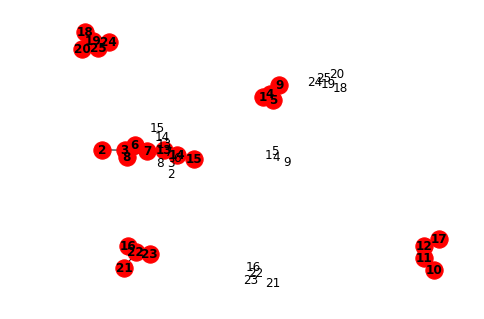

In [48]:
draw_graph(G_prime_req)

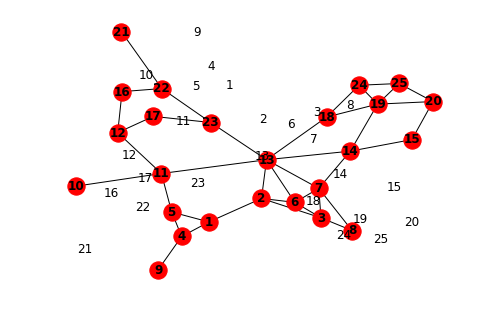

In [34]:
draw_graph(G_prime)

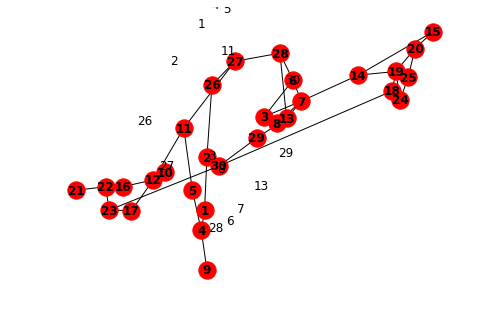

In [16]:
draw_graph(G_all)

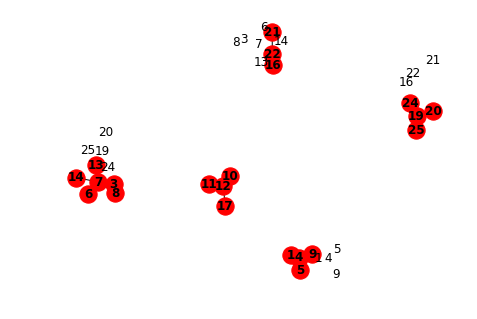

In [17]:
draw_graph(G_req_edges)

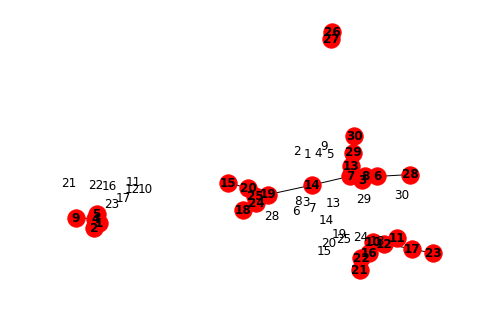

In [18]:
draw_graph(G_all_edges)

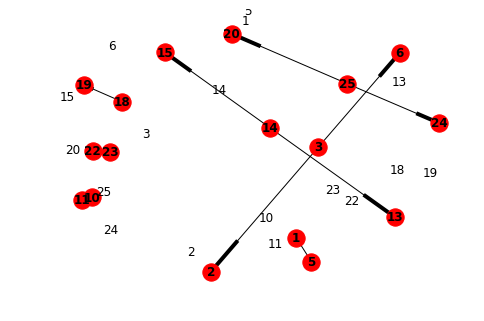

In [19]:
draw_graph(G_req_arcs)

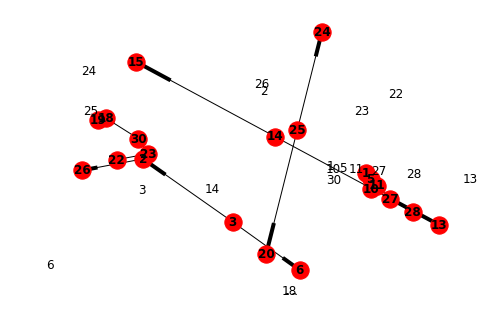

In [20]:
draw_graph(G_all_arcs)

In [21]:
G_prime._adj[1]

{5: {0: {'weight': 32, 'required': True}},
 4: {0: {'weight': 70, 'bidirection': True, 'required': True}},
 2: {35: {'required': False}}}

In [22]:
list(G_all_arcs.neighbors(1))

[5]